# Decoding in source's space

## Times series in labels extracted

### MLR 

In [ ]:
from tqdm import tqdm
def eval_classif_4(X, y):
    # Define parameters to test for grid search
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [1000,5000]
    }

    # Initialize the logistic regression model
    clf = LogisticRegression(n_jobs=-1)

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Initialize cross-validation
    cv_seed = int(time.time())
    n_splits = 100
    cvs = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=cv_seed)
    acc = pd.DataFrame()
    cm = np.zeros([n_splits, 3, 3])

    i_split = 0
    for train_ind, test_ind in tqdm(cvs.split(X, y)):
        # Train and test the classifier with the best parameters
        grid_search.fit(X[train_ind, :], y[train_ind])
        best_clf = grid_search.best_estimator_
        best_clf.fit(X[train_ind, :], y[train_ind])

        # Score on the training set
        d = {'type': ['train'], 'score': [best_clf.score(X[train_ind, :], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Score on the test set
        d = {'type': ['test'], 'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # Confusion matrix
        y_pred = best_clf.predict(X[test_ind, :])
        cm[i_split, :, :] = confusion_matrix(y[test_ind], y_pred, normalize='true')

        # Shuffle training indices
        train_ind_rand = np.random.permutation(train_ind)
        best_clf.fit(X[train_ind, :], y[train_ind_rand])

        # Score on the test set after shuffling
        d = {'type': ['shuf'], 'score': [best_clf.score(X[test_ind, :], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        i_split += 1

    return acc, cm

#### FIlter Band 

In [ ]:
Fs = 500  # fréquence d'échantillonnage
def filter_alpha_band(X, sfreq=Fs, l_freq=8, h_freq=12):
    """
    Filtre les time series dans la bande alpha (8-12 Hz) avec MNE.
    X : np.array shape (n_labels, n_times)
    Retourne un np.array de même shape filtré.
    """
    X_filt = np.empty_like(X)
    for i in range(X.shape[0]):
        X_filt[i, :] = mne.filter.filter_data(X[i, :], sfreq=sfreq, l_freq=l_freq, h_freq=h_freq, method='iir')
    return X_filt

def filter_beta_band(X, sfreq=Fs, l_freq=15, h_freq=32):
    """
    Filtre les time series dans la bande alpha (8-12 Hz) avec MNE.
    X : np.array shape (n_labels, n_times)
    Retourne un np.array de même shape filtré.
    """
    X_filt = np.empty_like(X)
    for i in range(X.shape[0]):
        X_filt[i, :] = mne.filter.filter_data(X[i, :], sfreq=sfreq, l_freq=l_freq, h_freq=h_freq, method='iir')
    return X_filt

def filter_gamma_band(X, sfreq=Fs, l_freq=40, h_freq=80):
    """
    Filtre les time series dans la bande alpha (8-12 Hz) avec MNE.
    X : np.array shape (n_labels, n_times)
    Retourne un np.array de même shape filtré.
    """
    X_filt = np.empty_like(X)
    for i in range(X.shape[0]):
        X_filt[i, :] = mne.filter.filter_data(X[i, :], sfreq=sfreq, l_freq=l_freq, h_freq=h_freq, method='iir')
    return X_filt

#### Dictionnaries to array function

In [ ]:
def dict_timeseries_to_array(timeseries_dict):
    labels = list(timeseries_dict.keys())
    n_labels = len(labels)
    
    # Supposons que chaque valeur est une liste contenant un seul array (1, n_times)
    n_times = timeseries_dict[labels[0]][0].shape[0]
    
    data_array = np.zeros((n_labels, n_times))
    
    for i, label in enumerate(labels):
        data_array[i, :] = timeseries_dict[label][0]
    
    return data_array, labels

#### STOP_IN and PUNCH-TROUGH just change 'si' in 'pt'

In [ ]:
# Conversion
X_solo_si, labels = dict_timeseries_to_array(ep_solo_si_series)
X_easy_si, _ = dict_timeseries_to_array(ep_easy_si_series)
X_hard_si, _ = dict_timeseries_to_array(ep_hard_si_series)

X_si, _  = dict_timeseries_to_array(ep_si_series)
X_all_si = np.vstack([X_solo_si, X_easy_si, X_hard_si])
print("X_solo_si shape:", X_solo_si.shape)
print("X_easy_si shape:", X_easy_si.shape)
print("X_hard_si shape:", X_hard_si.shape)
print("X_si shape:", X_si.shape)
print("X_all_si shape:", X_all_si.shape)

##### Alpha

In [ ]:
X_solo_alpha_si = filter_alpha_band(X_solo_si)
X_easy_alpha_si = filter_alpha_band(X_easy_si)
X_hard_alpha_si = filter_alpha_band(X_hard_si)

# Empilement des données et création des labels
X_all_alpha_si = np.vstack([X_solo_alpha_si, X_easy_alpha_si, X_hard_alpha_si])
y_all_alpha_si = np.array([0]*X_solo_si.shape[0] + [1]*X_easy_si.shape[0] + [2]*X_hard_si.shape[0])

print("Shape X_all_alpha_si:", X_all_alpha_si.shape)
print("Shape y_all_alpha_si:", y_all_alpha_si.shape)

# Réduction de dimension avec PCA
n_components = 66  # Ajuste selon besoin, 20 composants pour commencer
pca = PCA(n_components=n_components)
X_pca_alpha_si = pca.fit_transform(X_all_alpha_si)

print(f"Shape X after PCA: {X_pca_alpha_si.shape}")

#alpha

acc_alpha_1_si, cm_alpha_si = eval_classif_4(X_all_alpha_si, y_all_alpha_si) #MLR

# -----------------------
# Alpha plot MLR :
# -----------------------

# Alpha_MLR_Violonplot
sb.violinplot(data=acc_alpha_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_SI_Violonplot_source')
plt.show()

# Alpha MLR Matrix
plt.figure()
plt.imshow(cm_alpha_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_SI_Matrix_source')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()


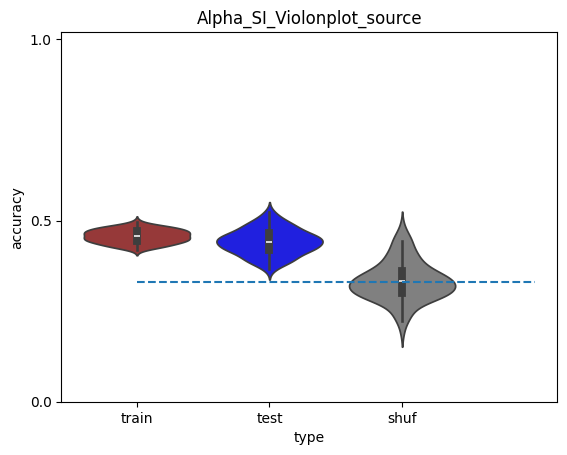 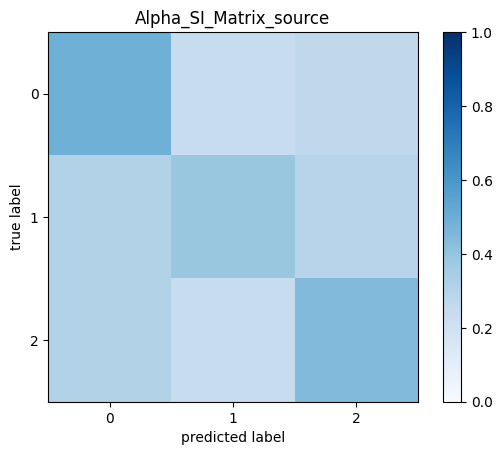 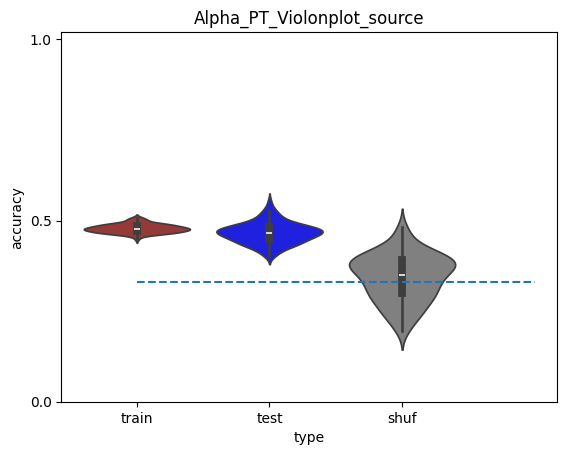 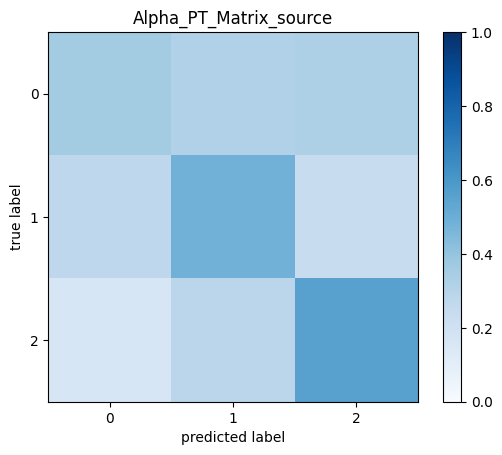

##### Beta

In [ ]:
# Filtrage en bande beta
X_solo_beta_si = filter_beta_band(X_solo_si)
X_easy_beta_si = filter_beta_band(X_easy_si)
X_hard_beta_si = filter_beta_band(X_hard_si)

# Empilement des données et création des labels
X_all_beta_si = np.vstack([X_solo_beta_si, X_easy_beta_si, X_hard_beta_si])
y_all_beta_si = np.array([0]*X_solo_si.shape[0] + [1]*X_easy_si.shape[0] + [2]*X_hard_si.shape[0])

print("Shape X_all_beta_si:", X_all_beta_si.shape)
print("Shape y_all_beta_si:", y_all_beta_si.shape)

# Réduction de dimension avec PCA
n_components = 66  # Ajuste selon besoin
pca = PCA(n_components=n_components)
X_pca_beta_si = pca.fit_transform(X_all_beta_si)

print(f"Shape X after PCA: {X_pca_beta_si.shape}")

# Classification MLR
n_features_to_select = 10
acc_beta_1_si, cm_beta_1_si = eval_classif_4(X_all_beta_si, y_all_beta_si) #MLR

# -----------------------
# Beta MLR Violinplot :
# -----------------------

sb.violinplot(data=acc_beta_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','green','gray'])
plt.yticks([0, 0.5, 1])
plt.plot([0, 3], [0.33, 0.33], '--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_SI_Violonplot_source')
plt.show()

# Beta MLR Confusion Matrix
plt.figure()
plt.imshow(cm_beta_1_si.mean(0), cmap='Greens', vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Beta_SI_Matrix_source')
plt.yticks([0, 1, 2])
plt.xticks([0, 1, 2])
plt.show()

 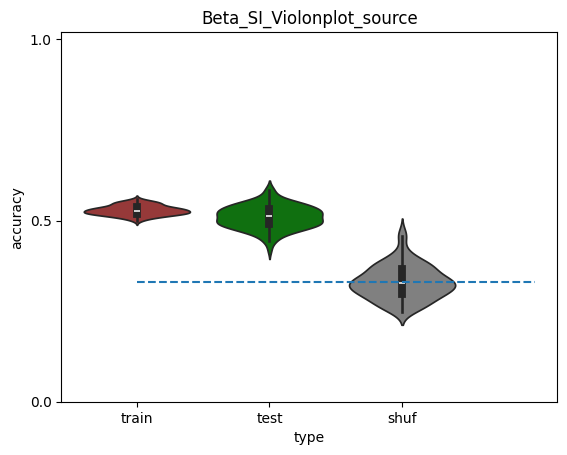 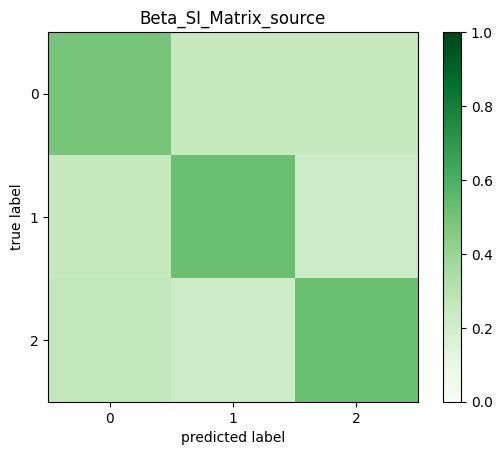 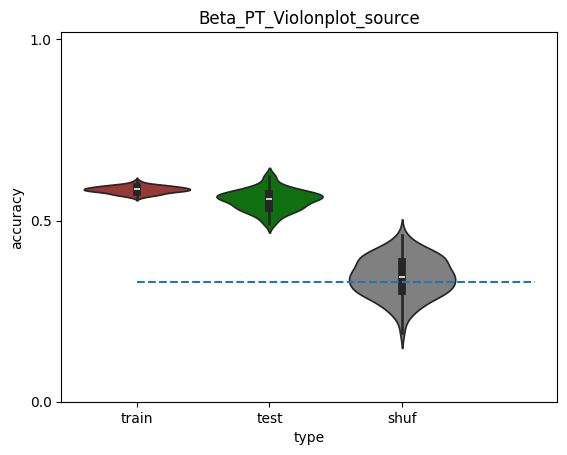 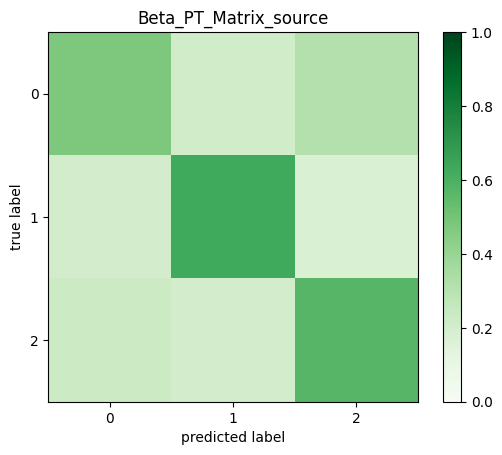

##### Gamma

In [ ]:
# Filtrage en bande gamma
X_solo_gamma_si = filter_gamma_band(X_solo_si)
X_easy_gamma_si = filter_gamma_band(X_easy_si)
X_hard_gamma_si = filter_gamma_band(X_hard_si)

# Empilement des données et création des labels
X_all_gamma_si = np.vstack([X_solo_gamma_si, X_easy_gamma_si, X_hard_gamma_si])
y_all_gamma_si = np.array([0]*X_solo_si.shape[0] + [1]*X_easy_si.shape[0] + [2]*X_hard_si.shape[0])

print("Shape X_all_gamma_si:", X_all_gamma_si.shape)
print("Shape y_all_gamma_si:", y_all_gamma_si.shape)

# Réduction de dimension avec PCA
n_components = 66  # Ajuste selon besoin
pca = PCA(n_components=n_components)
X_pca_gamma_si = pca.fit_transform(X_all_gamma_si)

print(f"Shape X after PCA: {X_pca_gamma_si.shape}")

# Classification MLR
acc_gamma_1_si, cm_gamma_si = eval_classif_4(X_all_gamma_si, y_all_gamma_si)  # MLR

# -----------------------
# Gamma MLR Violinplot :
# -----------------------

sb.violinplot(data=acc_gamma_1_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','red','gray'])
plt.yticks([0, 0.5, 1])
plt.plot([0, 3], [0.33, 0.33], '--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Gamma_SI_Violonplot_source')
plt.show()

# Gamma MLR Confusion Matrix
plt.figure()
plt.imshow(cm_gamma_si.mean(0), cmap='Reds', vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Gamma_SI_Matrix_source')
plt.yticks([0, 1, 2])
plt.xticks([0, 1, 2])
plt.show()


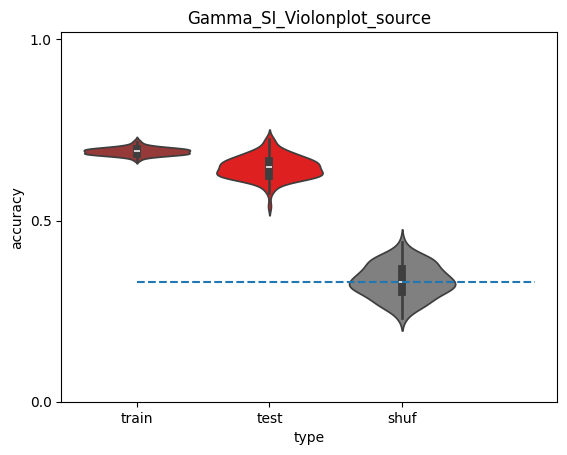 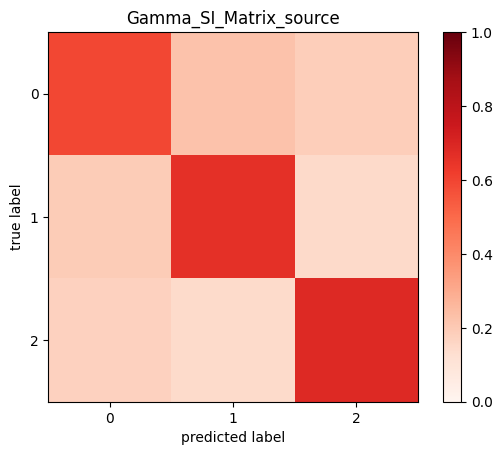 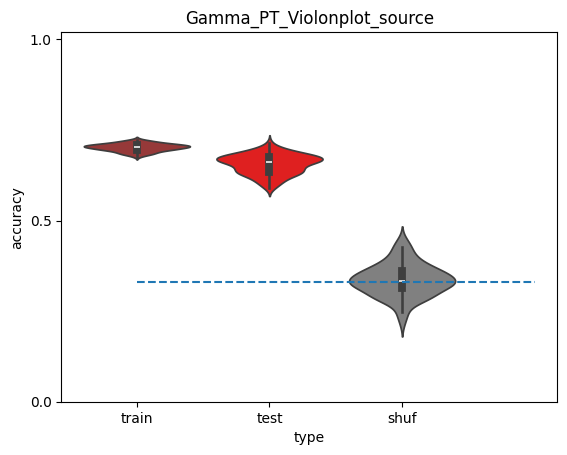 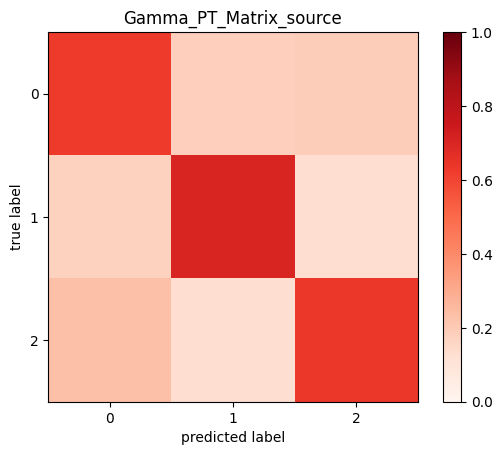

##### RFE on gamma

In [ ]:
# Assuming X_all_beta_si and y_all_beta_si are already defined and properly formatted
# Initialize the model
model = LogisticRegression(max_iter=1000)

# Initialize RFE with the number of features to select set to 10
n_features_to_select = 10
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)

# Fit RFE
rfe.fit(X_all_gamma_si, y_all_gamma_si)

# Get the selected features
selected_features = rfe.support_

# Get the rankings of all features
rankings = rfe.ranking_

# Print the selected features and their rankings
print("Selected features:", selected_features)
print("Feature rankings:", rankings)

import numpy as np

# Assuming rankings is your rankings array
rankings = np.array([140, 97, 69, 129, 128, 138, 105, 68, 122, 118, 70, 15, 
                     74, 107, 130, 125, 117, 45, 13, 71, 139, 103, 2, 90, 120, 104, 79, 119, 
                     106, 11, 1, 89, 57, 1, 35, 124, 20, 67, 131, 87, 4, 30, 1, 59, 77, 50, 
                     76, 137, 95, 135, 92, 58, 81, 51, 23, 1, 24, 108, 52, 19, 44, 56, 41, 
                     83, 88, 22, 1, 21, 123, 73, 93, 64, 43, 72, 29, 7, 111, 8, 1, 47, 109, 
                     84, 114, 94, 112, 85, 3, 48, 110, 49, 55, 66, 42, 101, 54, 26, 5, 62, 14, 
                     1, 115, 132, 121, 127, 133, 61, 12, 46, 63, 40, 18, 1, 17, 126, 10, 32, 134,
                       36, 53, 99, 16, 102, 113, 33, 78, 100, 136, 82, 28, 116, 27, 1, 60, 96, 39,
                         9, 31, 86, 75, 1, 65, 91, 25, 37, 80, 38, 98, 34, 6, 141
])

# Get the indices of the features sorted by their ranks
sorted_indices = np.argsort(rankings)

# Get the ranks of the sorted features
sorted_ranks = rankings[sorted_indices]

# If you have feature names, you can map them here
feature_names = Labels_to_extract  # List of your feature names
best_feature_names = [feature_names[i] for i in sorted_indices]

# Print the sorted ranks and indices
print("Sorted Indices:", sorted_indices)
print("Sorted Ranks:", sorted_ranks)

# Select the top N features
top_n = 10
best_feature_indices = sorted_indices[:top_n]
best_feature_ranks = sorted_ranks[:top_n]

print("Best Feature Indices:", best_feature_indices)
print("Best Feature Ranks:", best_feature_ranks)

# Get the indices of the features sorted by their ranks
sorted_indices = np.argsort(rankings)

# Get the names of the best features
top_n = 10
best_feature_indices = sorted_indices[:top_n]
best_feature_names = [feature_names[i] for i in best_feature_indices]
print("Best Feature Names:", best_feature_names)

Best Feature Names: [<Label | fsaverage, 'G_front_middle-lh', lh : 4252 vertices>, <Label | fsaverage, 'G_postcentral-rh', rh : 3138 vertices>, <Label | fsaverage, 'G_occipital_middle-lh', lh : 2098 vertices>, <Label | fsaverage, 'G_front_sup-rh', rh : 7866 vertices>, <Label | fsaverage, 'S_collat_transv_ant-rh', rh : 1068 vertices>, <Label | fsaverage, 'S_intrapariet_and_P_trans-rh', rh : 4277 vertices>, <Label | fsaverage, 'Lat_Fis-ant-Vertical-lh', lh : 496 vertices>, <Label | fsaverage, 'G_temp_sup-Lateral-lh', lh : 2784 vertices>, <Label | fsaverage, 'S_suborbital-rh', rh : 433 vertices>, <Label | fsaverage, 'S_pericallosal-rh', rh : 2326 vertices>]

##### Plot ROIs from RFE

In [ ]:
import os
import random
import mne
from mne.viz import Brain

subjects_dir = r"C:/Users/clari/Downloads/fsaverage"
os.environ["SUBJECTS_DIR"] = subjects_dir

all_labels = mne.read_labels_from_annot(
    subject='fsaverage',
    parc='aparc',
    subjects_dir=subjects_dir
)

wanted_names = {
    "S_temporal_sup-rh",
    "S_oc_middle_and_Lunatus-rh",
    "S_oc_sup_and_transversal-lh",
    "Pole_temporal-rh",
    "Pole_temporal-lh",
    "G_orbital-lh",
    "G_and_S_cingul-Mid-Post-rh",
    "G_pariet_inf-Supramar-rh",
    "S_circular_insula_sup-rh",
    "G_and_S_transv_frontopol-rh",
}


selected_labels = [lab for lab in all_labels if lab.name in wanted_names]

if len(selected_labels) < len(wanted_names):
    all_labels = mne.read_labels_from_annot(
        subject='fsaverage',
        parc='aparc.a2009s',
        subjects_dir=subjects_dir
    )
    selected_labels = [lab for lab in all_labels if lab.name in wanted_names]

print(f"Labels trouvés : {len(selected_labels)} / {len(wanted_names)}")
for lab in selected_labels:
    print(" •", lab.name, lab.hemi, len(lab.vertices), "sommets")

brain = Brain(
    subject='fsaverage',
    hemi='both',
    surf='inflated',
    subjects_dir=subjects_dir,
    background='white',
    cortex='classic'
)

for lab in selected_labels:
    color = (random.random(), random.random(), random.random())
    brain.add_label(lab, borders=False, color=color)


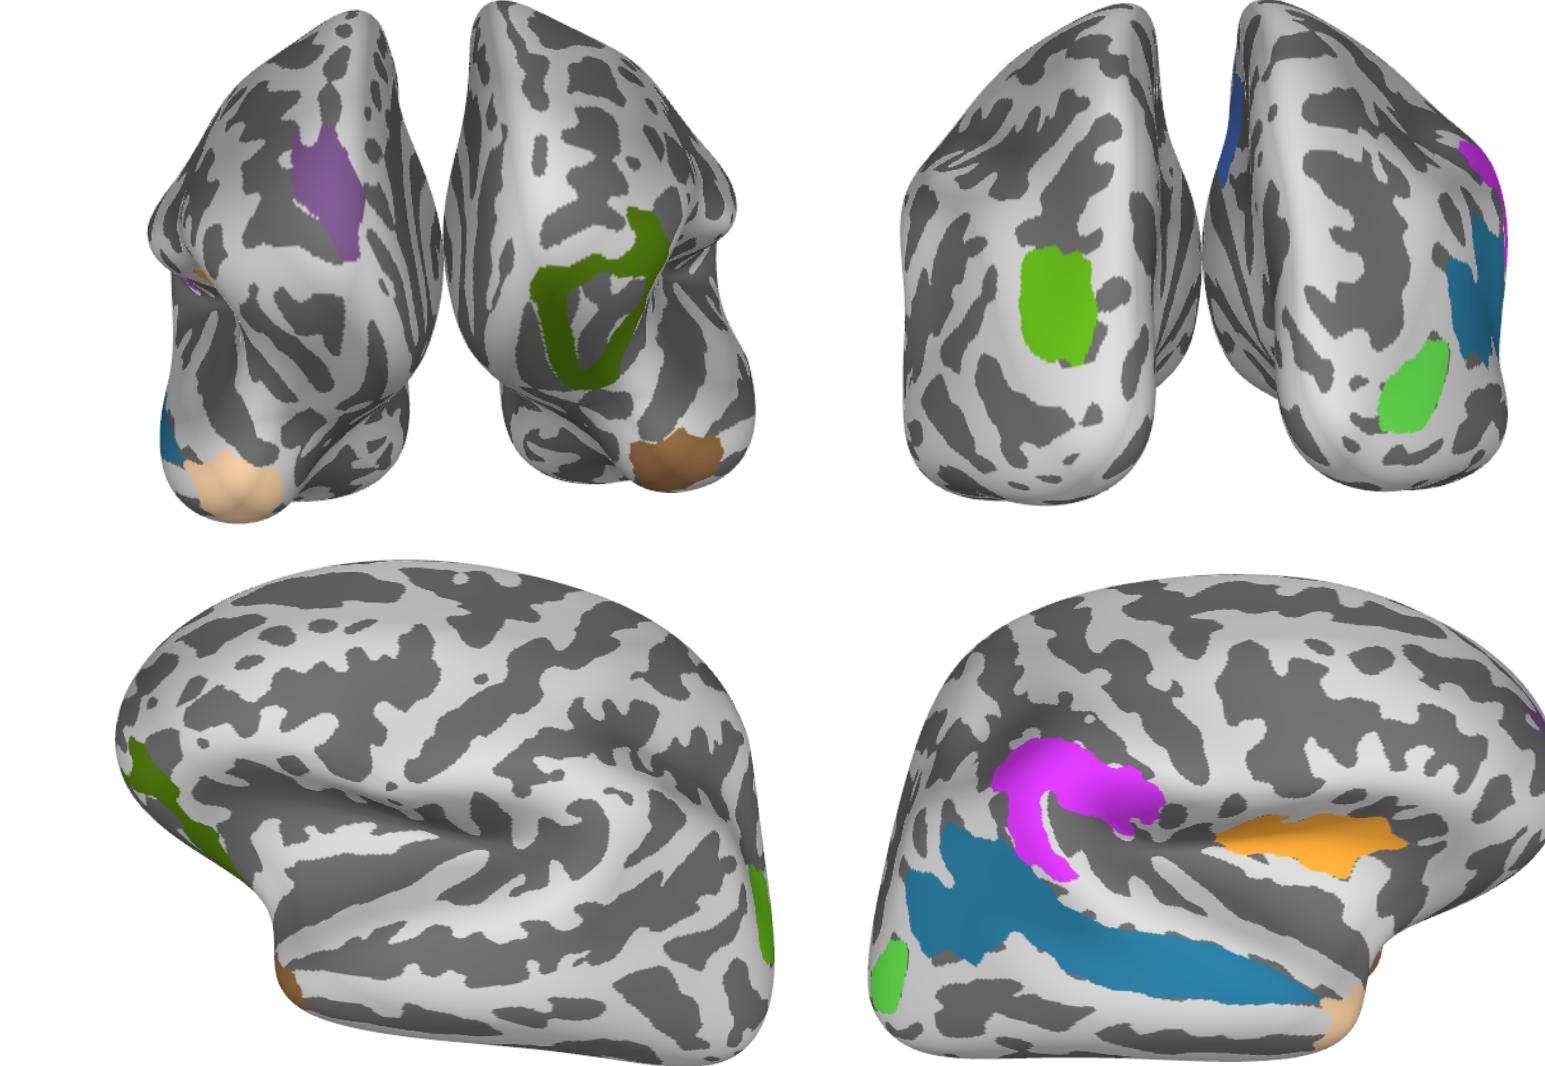 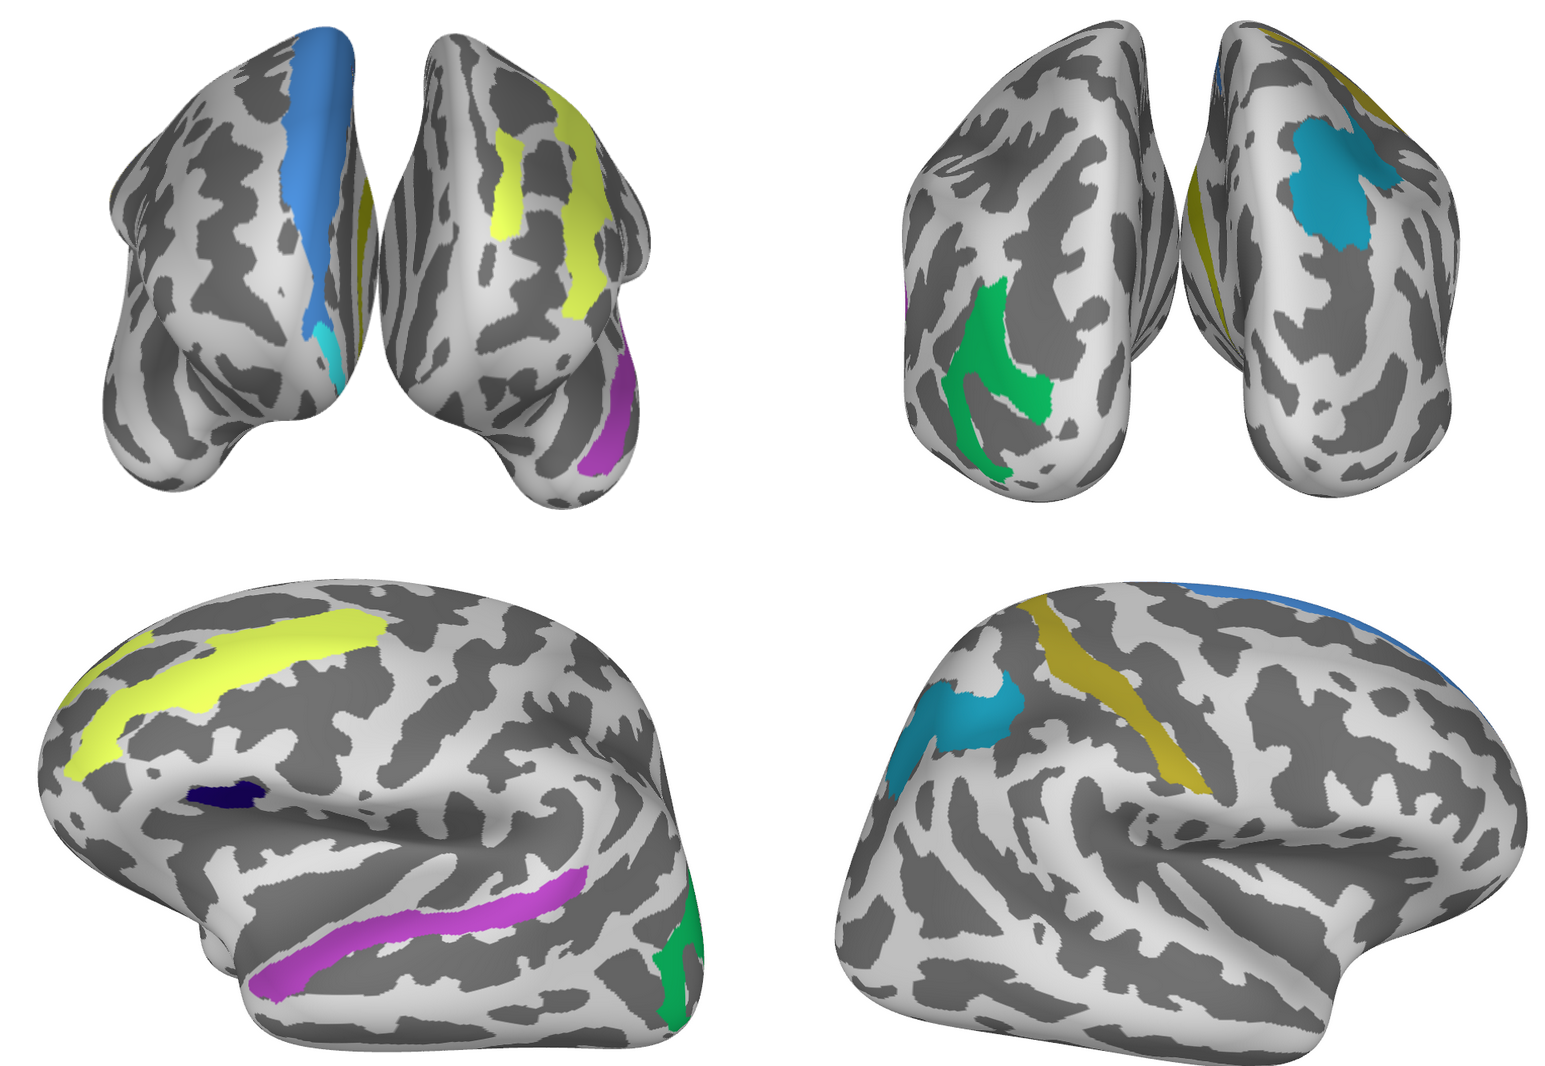

## Spectral coherency

In [ ]:
import os.path as op
import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.preprocessing import compute_proj_ecg, compute_proj_eog
import mne_connectivity
from mne_connectivity import envelope_correlation,envelope
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle
from mne_connectivity import spectral_connectivity_epochs

### Example for plotting the coherence for SI in gamma band just change 'si' in 'pt' for the other movement 

In [ ]:
def bp_gen(X_si):
    """Make a generator that band-passes on the fly."""
    for ts in X_si:
        yield mne.filter.filter_data(ts, sfreq, 40, 80)

# reshape → simulate as 1 epoch (n_epochs, n_signals, n_times)
data_ep_alpha = X_si.T[np.newaxis, :, :]  # (1, n_signals, n_times)


def plot_degree_2(corr, title, labels, inverse_operator, subjects_dir):
    threshold_prop = 0.15  # 15% des connexions les plus fortes
    degree = mne_connectivity.degree(corr, threshold_prop=threshold_prop)

    # Crée un STC à partir des labels et des valeurs de degré
    stc = mne.labels_to_stc(labels, values=degree, src=inverse_operator['src'])

    # Affichage avec les bons vertices LH/RH
    brain = stc.plot(
        clim=dict(kind="percent", lims=[75, 85, 95]),
        colormap="gnuplot",
        subjects_dir=subjects_dir,
        views="dorsal",
        hemi="both",
        smoothing_steps=25,
        time_label=title,
        size=(800, 600)
    )
    return brain


corr_obj = envelope_correlation(bp_gen(data_ep_alpha), orthogonalize="pairwise")
corr = corr_obj.combine()
corr = corr.get_data(output="dense")[:, :, 0]

def plot_corr(corr, title):
    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    ax.imshow(corr, cmap="viridis", clim=np.percentile(corr, [5, 95]))
    fig.suptitle(title)


plot_corr(corr, "Pairwise")


def plot_degree(corr, title):
    threshold_prop = 0.15  # percentage of strongest edges to keep in the graph
    degree = mne_connectivity.degree(corr, threshold_prop=threshold_prop)
    stc = mne.labels_to_stc(Labels_to_extract, degree)
    stc = stc.in_label(
        mne.Label(inverse_operator_si["src"][0]["vertno"], hemi="lh")
        + mne.Label(inverse_operator_si["src"][1]["vertno"], hemi="rh")
    )
    return stc.plot(
        clim=dict(kind="percent", lims=[75, 85, 95]),
        colormap="gnuplot",
        subjects_dir=subjects_dir,
        views="dorsal",
        hemi="both",
        smoothing_steps=25,
        time_label=title,
    )

brain = plot_degree_2(corr, "Alpha (pairwise, SI)", Labels_to_extract, inverse_operator_si, subjects_dir)

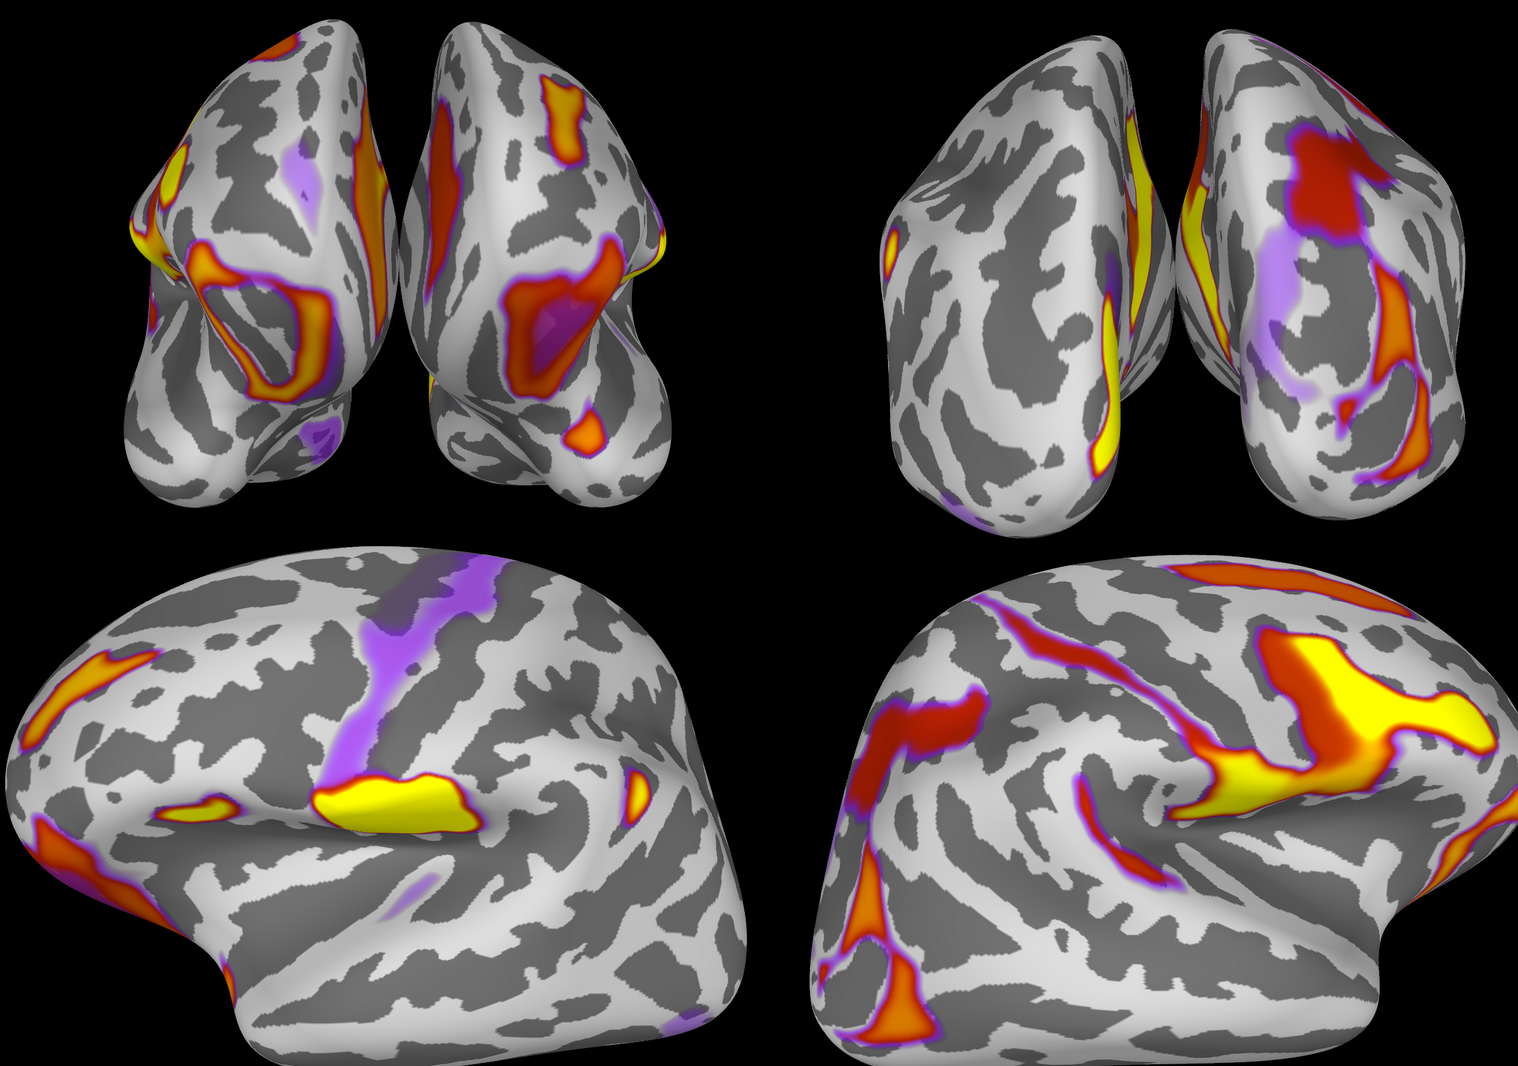 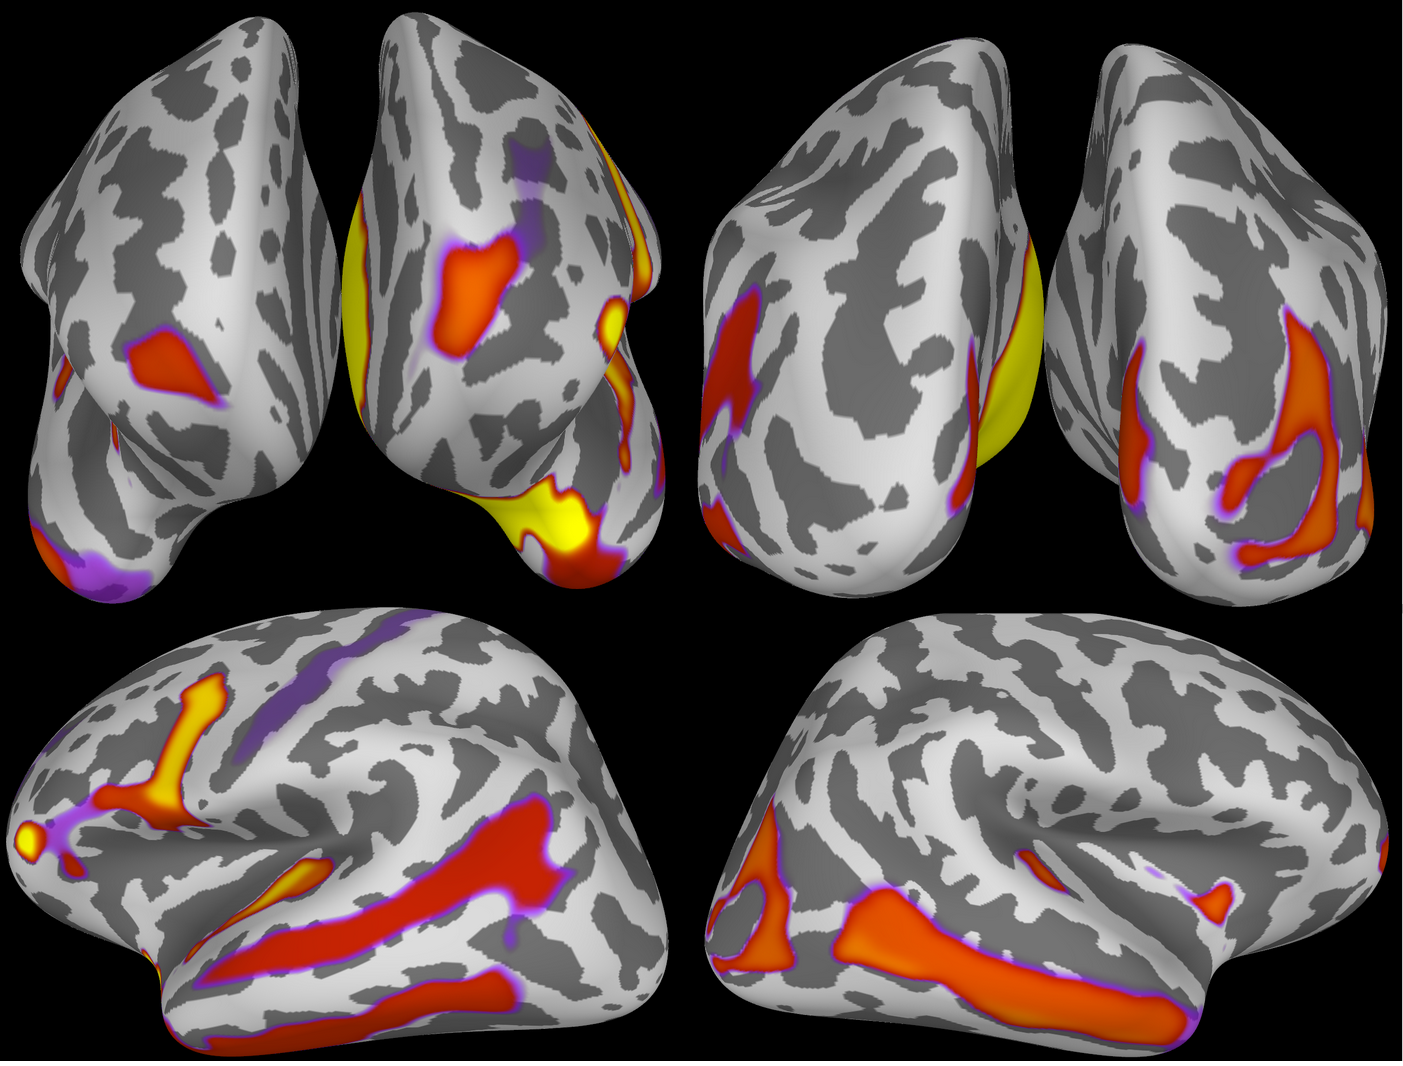

### MLR

#### STOP-IN and PUNCH-TROUGH for each band change 'si' in 'pt' if you want to see for the other movement

##### Alpha

In [ ]:
from scipy.signal import coherence

def compute_alpha_coherence_matrix(X, fs=500):  # fs: fréquence d'échantillonnage en Hz
    n_times, n_sources = X.shape[0],X.shape[1]
    coh_matrix = np.zeros((n_times,n_sources, n_sources))
    for i in range(n_sources):
        for j in range(i, n_sources):
            f, Cxy = coherence(X[:, i], X[:, j], fs=fs, nperseg=128)
            # Moyenne dans la bande alpha 8–12 Hz
            alpha_band = (f >= 8) & (f <= 12)
            mean_coh = np.mean(Cxy[alpha_band])
            coh_matrix[i, j] = coh_matrix[j, i] = mean_coh
    return coh_matrix

coh_solo_alha_si = compute_alpha_coherence_matrix(X_solo_si)
coh_easy_alpha_si = compute_alpha_coherence_matrix(X_easy_si)
coh_hard_alpha_si = compute_alpha_coherence_matrix(X_hard_si)

print(coh_solo_alha_si.shape)
print(coh_solo_alha_si.shape)
print(coh_solo_alha_si.shape)

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def upper_triangle_features(coh_matrix):
    # Prend une matrice (n_trials, n_sources, n_sources) et retourne (n_trials, n_features)
    n_trials, n_sources, _ = coh_matrix.shape
    indices = np.triu_indices(n_sources, k=1)
    features = np.array([coh_matrix[t][indices] for t in range(n_trials)])
    return features

# Extraire les features
X_solo = upper_triangle_features(coh_solo_alha_si)
X_easy = upper_triangle_features(coh_easy_alpha_si)
X_hard = upper_triangle_features(coh_hard_alpha_si)

# Créer X final et y
X = np.concatenate([X_solo, X_easy, X_hard], axis=0)
y = np.array([0]*X_solo.shape[0] + [1]*X_easy.shape[0] + [2]*X_hard.shape[0])

print(X.shape)
print(y.shape)

from sklearn.decomposition import PCA

# Appliquer la PCA sur toutes les données X
pca = PCA(n_components=401)  # ou un autre nombre selon ta préférence
X_pca = pca.fit_transform(X)

print("Nouvelle forme des données :", X_pca.shape)

#alpha

acc_alpha_src_corr_si, cm_alpha_si = eval_classif_4(X_pca, y) #MLR

# -----------------------
# Alpha plot MLR :
# -----------------------

# Alpha_MLR_Violonplot
sb.violinplot(data=acc_alpha_src_corr_si, x='type', y='score', hue='type', density_norm='width', palette=['brown','blue','gray'])
plt.yticks([0,0.5,1])
plt.plot([0,3],[0.33,0.33],'--')
plt.axis(ymin=0)

plt.ylabel('accuracy')
plt.axis(ymax=1.02)
plt.title('Alpha_SI_Violonplot_source')
plt.show()

# Alpha MLR Matrix
plt.figure()
plt.imshow(cm_alpha_si.mean(0), cmap='Blues',vmin=0.0, vmax=1.0)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.colorbar()
plt.title('Alpha_SI_Matrix_source')
plt.yticks([0,1,2])
plt.xticks([0,1,2])
plt.show()

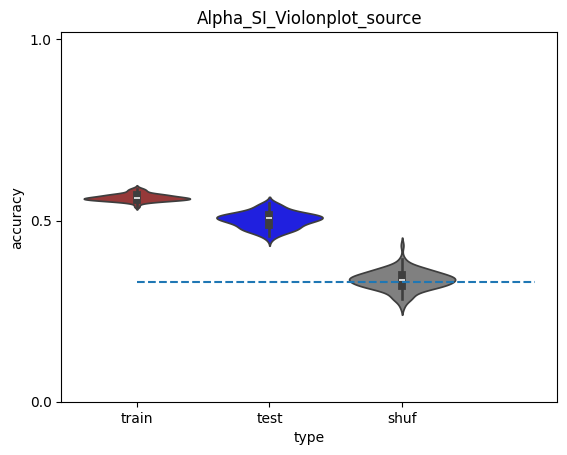 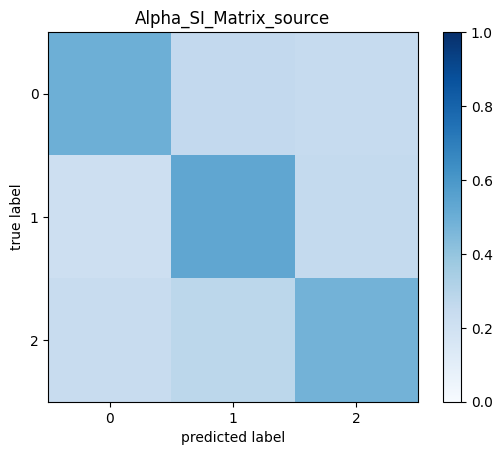 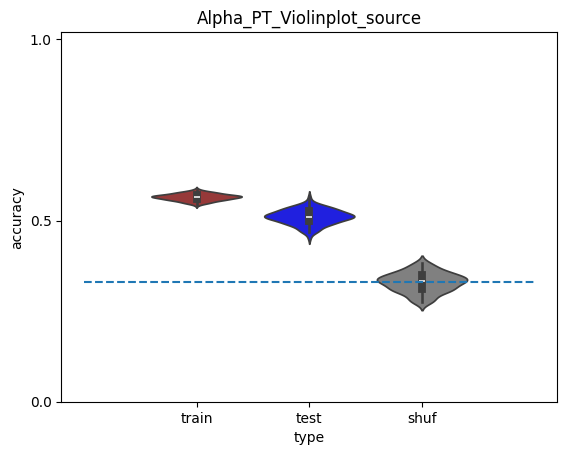 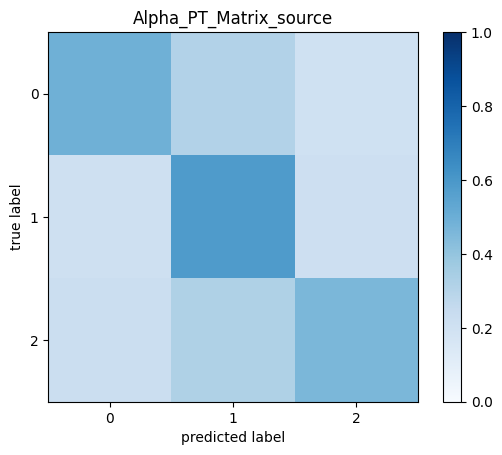

##### Beta

In [ ]:
from scipy.signal import coherence
import numpy as np

def compute_beta_coherence_matrix(X, fs=500):  # fs: sampling frequency in Hz
    n_times, n_sources = X.shape[0], X.shape[1]
    coh_matrix = np.zeros((n_times, n_sources, n_sources))  

    for i in range(n_sources):
        for j in range(i, n_sources):
            f, Cxy = coherence(X[:, i], X[:, j], fs=fs, nperseg=128)
            # Average in the beta band 13–30 Hz
            beta_band = (f >= 15) & (f <= 32)
            mean_coh = np.mean(Cxy[beta_band])
            coh_matrix[i, j] = coh_matrix[j, i] = mean_coh

    return coh_matrix

# Assuming X_solo_si, X_easy_si, and X_hard_si are defined
coh_solo_beta_si = compute_beta_coherence_matrix(X_solo_si)
coh_easy_beta_si = compute_beta_coherence_matrix(X_easy_si)
coh_hard_beta_si = compute_beta_coherence_matrix(X_hard_si)

print(coh_solo_beta_si.shape)
print(coh_easy_beta_si.shape)
print(coh_hard_beta_si.shape)

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def upper_triangle_features(coh_matrix):
    # Takes a matrix of shape (n_trials, n_sources, n_sources) and returns (n_trials, n_features)
    n_trials, n_sources, _ = coh_matrix.shape
    indices = np.triu_indices(n_sources, k=1)
    features = np.array([coh_matrix[t][indices] for t in range(n_trials)])
    return features

# Assuming coh_solo_beta_si, coh_easy_beta_si, and coh_hard_beta_si are already computed
# Extract features using beta coherence matrices
X_solo = upper_triangle_features(coh_solo_beta_si)
X_easy = upper_triangle_features(coh_easy_beta_si)
X_hard = upper_triangle_features(coh_hard_beta_si)

# Create final X and y
X = np.concatenate([X_solo, X_easy, X_hard], axis=0)
y = np.array([0]*X_solo.shape[0] + [1]*X_easy.shape[0] + [2]*X_hard.shape[0])

print(X.shape)
print(y.shape)

from sklearn.decomposition import PCA

# Appliquer la PCA sur toutes les données X
pca = PCA(n_components=401)  # ou un autre nombre selon ta préférence
X_pca = pca.fit_transform(X)

print("Nouvelle forme des données :", X_pca.shape)

# Assuming you have computed beta band data and stored it in acc_beta_si and cm_beta_si
acc_beta_src_corr_si, cm_beta_si = eval_classif_4(X_pca, y)  # MLR for beta band

# -----------------------
# Beta plot MLR:
# -----------------------

# Beta_MLR_Violinplot
sb.violinplot(data=acc_beta_src_corr_si, x='type', y='score', hue='type', density_norm='width', palette=['brown', 'green', 'gray'])
plt.yticks([0, 0.5, 1])
plt.plot([-1, 3], [0.33, 0.33], '--')
plt.axis(ymin=0)
plt.ylabel('Accuracy')
plt.axis(ymax=1.02)
plt.title('Beta_SI_Violinplot_source')
plt.show()

# Beta MLR Matrix
plt.figure()
plt.imshow(cm_beta_si.mean(0), cmap='Greens', vmin=0.0, vmax=1.0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.title('Beta_SI_Matrix_source')
plt.yticks([0, 1, 2])
plt.xticks([0, 1, 2])
plt.show()


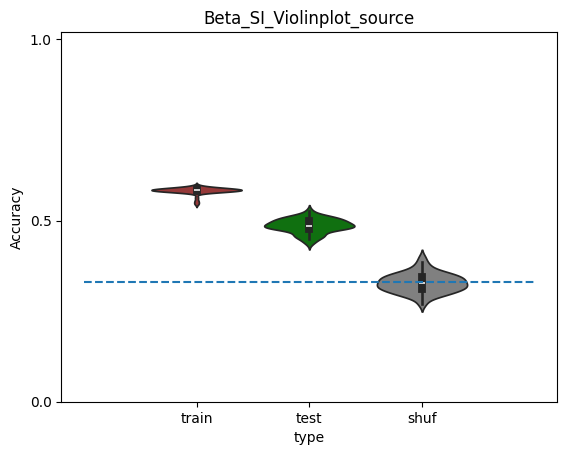 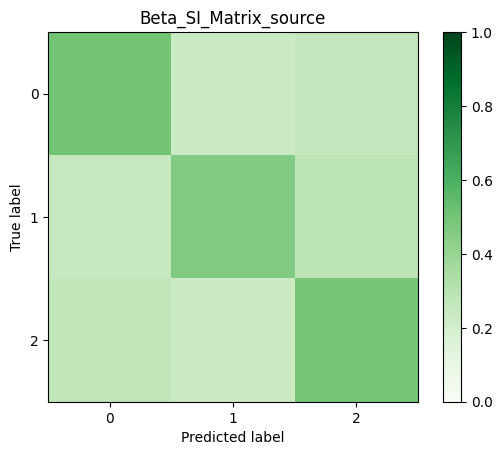 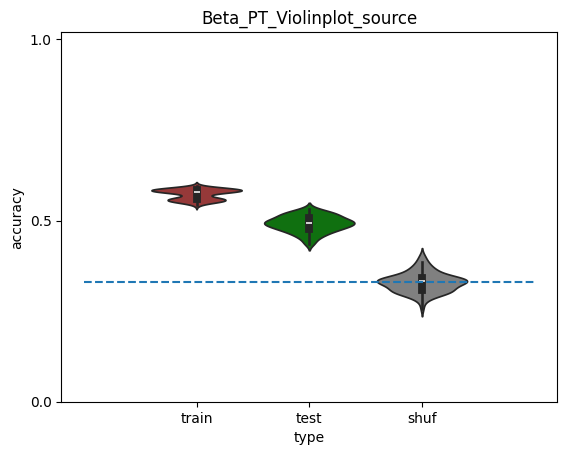 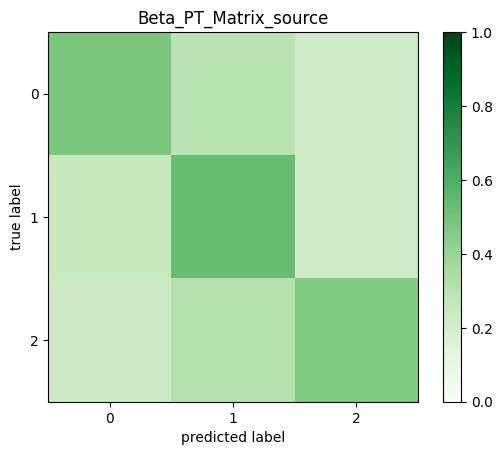

##### Gamma

In [ ]:
from scipy.signal import coherence
import numpy as np

def compute_gamma_coherence_matrix(X, fs=500):  # fs: sampling frequency in Hz
    n_times, n_sources = X.shape[0], X.shape[1]
    coh_matrix = np.zeros((n_times, n_sources, n_sources))

    for i in range(n_sources):
        for j in range(i, n_sources):
            f, Cxy = coherence(X[:, i], X[:, j], fs=fs, nperseg=128)
            # Average in the gamma band 30–100 Hz
            gamma_band = (f >= 40) & (f <= 80)
            mean_coh = np.mean(Cxy[gamma_band])
            coh_matrix[i, j] = coh_matrix[j, i] = mean_coh 

    return coh_matrix

# Assuming X_solo_si, X_easy_si, and X_hard_si are defined
coh_solo_gamma_si = compute_gamma_coherence_matrix(X_solo_si)
coh_easy_gamma_si = compute_gamma_coherence_matrix(X_easy_si)
coh_hard_gamma_si = compute_gamma_coherence_matrix(X_hard_si)

print(coh_solo_gamma_si.shape)
print(coh_easy_gamma_si.shape)
print(coh_hard_gamma_si.shape)

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def upper_triangle_features(coh_matrix):
    # Takes a matrix of shape (n_trials, n_sources, n_sources) and returns (n_trials, n_features)
    n_trials, n_sources, _ = coh_matrix.shape
    indices = np.triu_indices(n_sources, k=1)
    features = np.array([coh_matrix[t][indices] for t in range(n_trials)])
    return features

# Assuming coh_solo_gamma_si, coh_easy_gamma_si, and coh_hard_gamma_si are already computed
# Extract features using gamma coherence matrices
X_solo = upper_triangle_features(coh_solo_gamma_si)
X_easy = upper_triangle_features(coh_easy_gamma_si)
X_hard = upper_triangle_features(coh_hard_gamma_si)

# Create final X and y
X = np.concatenate([X_solo, X_easy, X_hard], axis=0)
y = np.array([0]*X_solo.shape[0] + [1]*X_easy.shape[0] + [2]*X_hard.shape[0])

print(X.shape)
print(y.shape)

from sklearn.decomposition import PCA

# Appliquer la PCA sur toutes les données X
pca = PCA(n_components=401)  # ou un autre nombre selon ta préférence
X_pca = pca.fit_transform(X)

print("Nouvelle forme des données :", X_pca.shape)


# Assuming you have computed gamma band data and stored it in acc_gamma_si and cm_gamma_si
acc_gamma_src_corr_si, cm_gamma_si = eval_classif_4(X_pca, y)  # MLR for gamma band

# -----------------------
# Gamma plot MLR:
# -----------------------

# Gamma_MLR_Violinplot
sb.violinplot(data=acc_gamma_src_corr_si, x='type', y='score', hue='type', density_norm='width', palette=['brown', 'red', 'gray'])
plt.yticks([0, 0.5, 1])
plt.plot([-1, 3], [0.33, 0.33], '--')
plt.axis(ymin=0)
plt.ylabel('Accuracy')
plt.axis(ymax=1.02)
plt.title('Gamma_SI_Violinplot_source')
plt.show()

# Gamma MLR Matrix
plt.figure()
plt.imshow(cm_gamma_si.mean(0), cmap='Reds', vmin=0.0, vmax=1.0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.title('Gamma_SI_Matrix_source')
plt.yticks([0, 1, 2])
plt.xticks([0, 1, 2])
plt.show()

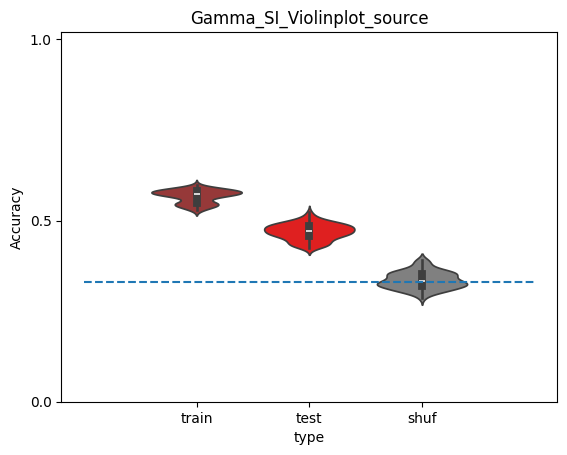 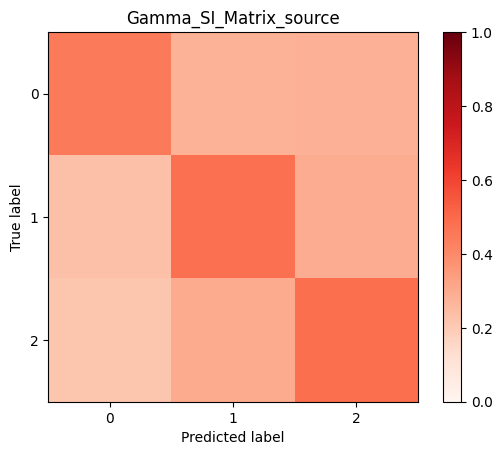 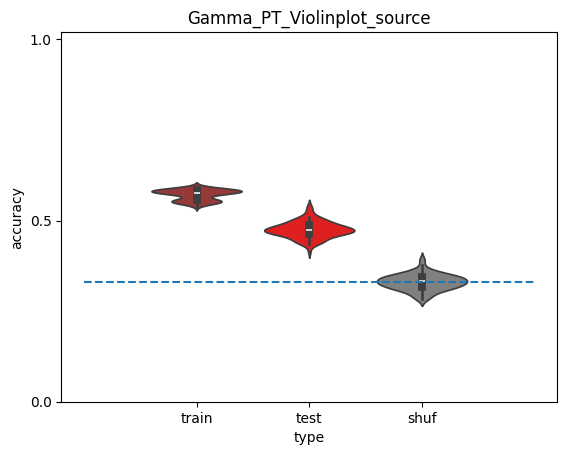 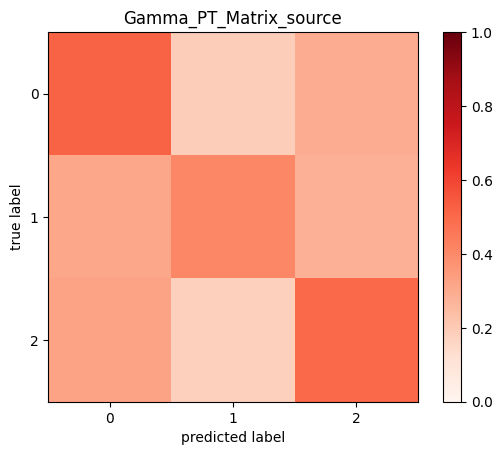